In [1]:
from seagul.rl.ars.ars_pipe import ars
from seagul.nn import MLP
import torch
import matplotlib.pyplot as plt
from seagul.mesh import variation_dim
import time
import copy
import gym


import xarray as xr
import numpy as np
import pandas as pd

import os

In [2]:
def identity(rews,obs,acts):
    return rews

def vardiv(rews, obs, acts):
    return rews/variation_dim(obs)

def varmul(rews, obs, acts):
    return rews*variation_dim(obs)

def rough_measure(x):
    d = torch.stack([x[t,:] - x[t-1,:] for t in range(1,x.shape[0])])
    return d.std()#$/(torch.abs(d.mean()))

def rmul(rews, obs, acts):
    return rews*rough_measure(obs)

def rdiv(rews, obs, acts):
    return rews/rough_measure(obs)

def do_rollout(env, policy, render=False):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while not done:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())
        if render:
            env.render()
            time.sleep(.05)

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length


def do_long_rollout(env, policy, ep_length):
    torch.autograd.set_grad_enabled(False)

    act_list = []
    obs_list = []
    rew_list = []

    dtype = torch.float32
    obs = env.reset()
    done = False
    cur_step = 0

    while cur_step < ep_length:
        obs = torch.as_tensor(obs, dtype=dtype).detach()
        obs_list.append(obs.clone())

        act = policy(obs)
        obs, rew, done, _ = env.step(act.numpy())

        act_list.append(torch.as_tensor(act.clone()))
        rew_list.append(rew)

        cur_step += 1

    ep_length = len(rew_list)
    ep_obs = torch.stack(obs_list)
    ep_act = torch.stack(act_list)
    ep_rew = torch.tensor(rew_list, dtype=dtype)
    ep_rew = ep_rew.reshape(-1, 1)

    torch.autograd.set_grad_enabled(True)
    return ep_obs, ep_act, ep_rew, ep_length

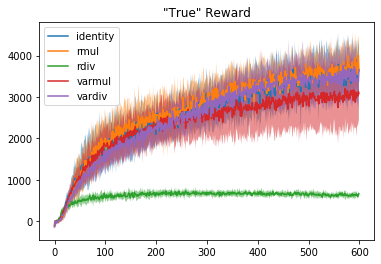

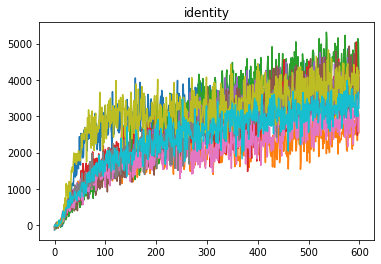

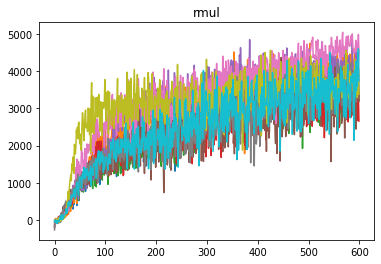

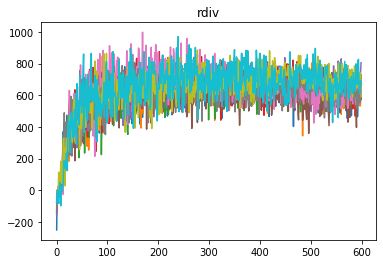

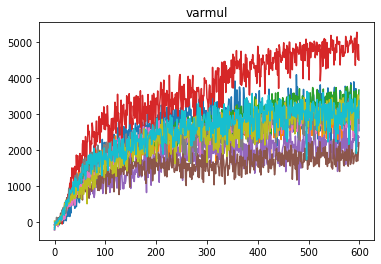

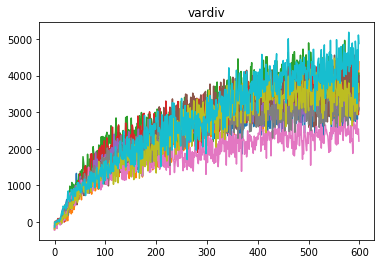

<Figure size 432x288 with 0 Axes>

In [3]:
data = torch.load("./data4/HalfCheetah-v2.xr")

policy_dict = data.policy_dict
rews = data.rews
exp_names = [fn.__name__ for fn in data.attrs['post_fns']]
num_seeds = len(policy_dict['identity'])

#policy_dict = torch.load("./data/mjw_longermul.pol_dict")
#rews = torch.load("./data/mjw_longermul.data")

means = rews.mean(dim="trial")
stds = rews.std(dim="trial")

plt.plot(means.T)
plt.legend(exp_names)
ci = stds

for mean, c in zip(means, ci):
    plt.fill_between([t for t in range(len(mean))], (mean-c), (mean+c), alpha=.5)
plt.title("\"True\" Reward")
plt.figure()

for exp_name in exp_names:  
    plt.plot(rews.loc[exp_name].T)
    plt.title(exp_name)
    plt.figure()

CPU times: user 16.5 s, sys: 100 ms, total: 16.6 s
Wall time: 16.7 s


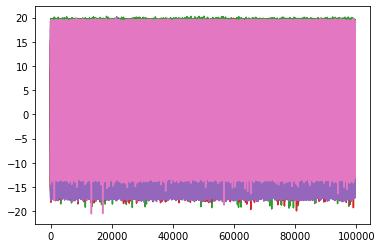

In [10]:
env_name = "HalfCheetah-v2"

policy = policy_dict['vardiv'][3]
env = gym.make(env_name)
%time o,a,r,l = do_long_rollout(env, policy, ep_length= 100000)
#o,a,r,l = do_rollout(env, policy)

start_idx = 500
plt.plot(o[start_idx:])
target = o[start_idx:]

In [5]:
from seagul.mesh import create_mesh, variation_dim, mesh_dim, create_mesh_dict

In [11]:
#%time create_mesh(target, .01)
%time create_mesh_dict(target, 2)

CPU times: user 5.15 s, sys: 237 ms, total: 5.39 s
Wall time: 5.39 s


{(tensor(-0.1400),
  tensor(-0.0100),
  tensor(0.5800),
  tensor(-0.1700),
  tensor(0.0400),
  tensor(-0.9800),
  tensor(-0.3400),
  tensor(0.0200),
  tensor(4.9800),
  tensor(-0.1900),
  tensor(3.6900),
  tensor(3.8200),
  tensor(-12.8600),
  tensor(14.2600),
  tensor(-13.2400),
  tensor(-0.9100),
  tensor(-14.3800)): 1,
 (tensor(-0.1200),
  tensor(0.0300),
  tensor(0.5700),
  tensor(-0.4300),
  tensor(0.7300),
  tensor(-0.6100),
  tensor(-0.0500),
  tensor(-0.5300),
  tensor(5.4100),
  tensor(0.5300),
  tensor(-0.3200),
  tensor(-2.6200),
  tensor(0.4600),
  tensor(10.0300),
  tensor(16.5900),
  tensor(9.0800),
  tensor(-0.5000)): 1,
 (tensor(-0.1400),
  tensor(-0.0400),
  tensor(-0.0600),
  tensor(0.4500),
  tensor(0.5100),
  tensor(0.2200),
  tensor(0.1800),
  tensor(-0.4300),
  tensor(4.6900),
  tensor(-0.5500),
  tensor(-2.8800),
  tensor(-14.4300),
  tensor(18.7900),
  tensor(-9.6000),
  tensor(14.6300),
  tensor(-4.5700),
  tensor(-2.9400)): 1,
 (tensor(-0.1500),
  tensor(-0.14

In [ ]:
m,w = create_mesh(target,1)
len(m)

In [ ]:
mdim, _, _ = mesh_dim(target, .1)
cdim, _, _ = mesh_dim(target, .1)
vdim = variation_dim(target)

print(mdim, cdim, vdim)

In [ ]:
from seagul.mesh import create_mesh, mesh_dim, conservative_mesh_dim, variation_dim

init_d = 1e-6
num_runs = 1
post_fns = [identity, vardiv, rmul]

msize1 = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

msize2 = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

msize4 = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

mdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

cdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

vdims = xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})

rdims =  xr.DataArray(np.zeros((len(post_fns), num_seeds, num_runs)),
                dims = ("post", "seed", "run"),
                coords = {"post": [fn.__name__ for fn in post_fns]})


for post_fn in post_fns:
    for i in range(num_seeds):
        for j in range(num_runs):
            policy = policy_dict[post_fn.__name__][i]
            o,a,r,l = do_long_rollout(env, policy, ep_length=100000)
            target = o[500:]
            target = (target - target.mean(dim=0))/target.std(dim=0)
            #m,w = create_mesh(target,init_d)
            #assert(len(m) == len(target))
            
            m,w = create_mesh(target,.001)
            msize4.loc[post_fn.__name__,i,j] = len(m)
            
            m,w = create_mesh(target,.01)
            msize2.loc[post_fn.__name__,i,j] = len(m)
            
            m,w = create_mesh(target,.1)
            msize1.loc[post_fn.__name__,i,j] = len(m)

            #mdims.loc[post_fn.__name__,i,j] , _, _ = mesh_dim(target, init_d)
            #cdims.loc[post_fn.__name__,i,j], _, _ = conservative_mesh_dim(target, init_d)
            vdims.loc[post_fn.__name__,i,j] = variation_dim(target)
            rdims.loc[post_fn.__name__,i,j] = rough_measure(target).item()



In [ ]:
msize1.std(dim='seed')

In [ ]:
msize2.std(dim='seed')

In [ ]:
msize4.mean(dim='seed')

In [ ]:
vdims.mean(dim='seed')

In [ ]:
mdims.mean(dim='seed')

In [ ]:
from seagul.mesh import create_mesh_dict

In [ ]:
seed = 0
for post_name in ['identity' ,'vardiv' , 'rmul']: #seed = 10
    for run in [0,1,2,3,4]:
        o,a,r,l = do_long_rollout(env,policy_dict[post_name][seed], ep_length=10000)

        #print("reward:", sum(r))
        #print("variation_dim: ", variation_dim(o))
        #print("roughness: ", rough_measure(o))
        #plt.plot(o)
        #plt.figure()
        #plt.plot(a)

        import scipy.io 
        import os

        o = np.array(o)
        a = np.array(a)
        r = np.array(r)
        os.makedirs(f"./k/env_{env_name}/post_{post_name}/seed_{seed}", exist_ok=True)
        scipy.io.savemat(f"./k/env_{env_name}/post_{post_name}/seed_{seed}/run_{run}.mat", mdict = {"obs":o, "act":a, "rew":r})